# Spin-off project from Thesis: Curtailment 

## Advanced case

In this workbook, we consider the advanced case equivalent to the study of the second limit. The grid operation is computed in this analysis.  

*Note:* The code is modified from ```05_03_Integration_CA_generative.ipynb``` from the main folder.

In [74]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pytz
from dateutil import tz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [75]:
[region, zipcode] = ['CAISO','92562']
#[region, zipcode] = ['PJM','08641']
datasource = 'L'

In [76]:
####################################################Import data##############################################

#################### Import load data from CAISO with full forecast #######################################

mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
dataDir = mainDir + '/data/load/' + region +'/'
loaddata = pd.read_csv(dataDir +'/load_with_full_forecast_integration.csv')
loaddata['tsLocal'] = loaddata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [77]:
#for load, make a reference to previous week and previous year 
#Day ahead prediction
loaddata['load-predict-DayAhead-ref'] = 0.5*(loaddata['load-1w']+loaddata['load-1y']) 

#Smootening
loaddata['load-predict-DayAhead-ref+1'] = float('NaN')
loaddata['load-predict-DayAhead-ref-1'] = float('NaN')
loaddata.loc[1:loaddata.shape[0],'load-predict-DayAhead-ref-1'] = list(loaddata['load-predict-DayAhead-ref'].iloc[0:(loaddata.shape[0]-1)])
loaddata.loc[0:(loaddata.shape[0]-2),'load-predict-DayAhead-ref+1'] = list(loaddata['load-predict-DayAhead-ref'].iloc[1:(loaddata.shape[0])])
loaddata['load-predict-DayAhead'] = \
    (loaddata['load-predict-DayAhead-ref']+loaddata['load-predict-DayAhead-ref-1']+loaddata['load-predict-DayAhead-ref+1'])/3.0


In [78]:
#################### Import PV output data and with full forecast #######################################

#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
PVdata = pd.read_csv(dataDir +'/data_with_full_forecast_integration.csv')
PVdata['tsLocal'] = PVdata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [79]:
#################### Define scope, join load data, and join PV data #######################################

StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15) #Here we are only interested in an hour operation
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,loaddata,on=['tsLocal'], how = 'left') 

index = [(d.columns=='load').nonzero()[0][0],(d.columns=='load_ref').nonzero()[0][0], \
         (d.columns=='load-predict-DayAhead').nonzero()[0][0]]
#Interpolate load values to 15 mins
for j in index:
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
            #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

d = pd.merge(d,PVdata,on=['tsLocal'], how = 'left') 

## Set up important quantities and simulation period

In [80]:
#Check column names needed and make it solid
Data = d
Data_full = Data

In [81]:
#Define scale of PV deployment: maximum load of the year
maxload = np.max(Data_full['load'])
print maxload

43479.84


In [82]:
d_imm = Data_full
d_imm['load-1'] = float('NaN')
d_imm.loc[1:Data.shape[0],'load-1'] = list(d_imm['load'].iloc[0:(d_imm.shape[0]-1)])
maxramprate = np.max(np.absolute(d_imm['load']- d_imm['load-1'])*4)
print maxramprate

4315.41


In [83]:
#We simulate only last quarter of 2014
d = Data_full

#Assign specific period
StartDate = datetime.date(2014,10,1)
offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

Data = d[offset:]
Data = Data.reset_index()
Data.drop('index', axis=1, inplace=True)
Data_original = Data

In [84]:
Data = Data_original

## Day ahead market

Perform day ahead prediction and calculate the ramp rate.

In the case of curtailment, we need to consider the case when the day-head predicted net load is less than zero. In that case, we cap it to zero.

In [85]:
def DayAheadPredictionAndRamprate(Data):
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0

    #for PV, use expectedr to predict solar power
    Data['netload-predict-DayAhead'] =  - PenetrationLevel * Data['mpower'] * Data['expectedr']  * maxload 
    Data['netload-predict-DayAhead'][Data['mpower'].isnull()] = 0
    Data['netload-predict-DayAhead'] = Data['netload-predict-DayAhead'] + Data['load-predict-DayAhead']
    
    #Apply curtailment when the net load is less than zero
    Data['netload-predict-DayAhead'] = Data['netload-predict-DayAhead'].map(lambda x: max(x,0))
    
    return Data
    

Do energy scheduling to match up without exceeding maximum ramp rate

In [86]:
CapRampRateRatio = 1.05

def DayAheadMarketAssignment(Data):
    
    AlertBoolean = 0
    DayAheadRampCount = 0

    Data['netload-assign-DayAhead'] = float('NaN')
        
    column_index_predict = (Data.columns=='netload-predict-DayAhead').nonzero()[0][0]
    column_index_assign = (Data.columns=='netload-assign-DayAhead').nonzero()[0][0]
    Data.iloc[0, column_index_assign] = Data.iloc[0, column_index_predict]
    for i in range(1,Data.shape[0]):
        if (not np.isnan(Data.iloc[i, column_index_predict])):
            if np.absolute(Data.iloc[i, column_index_predict]-Data.iloc[i-1, column_index_assign])*4 \
                   < CapRampRateRatio*maxramprate:
                Data.iloc[i, column_index_assign] = Data.iloc[i, column_index_predict]
            else:
                #can assign at most the max ramprate
                AlertBoolean = 1
                DayAheadRampCount = DayAheadRampCount+1
                if Data.iloc[i-1, column_index_assign] < Data.iloc[i, column_index_predict]:
                    Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign] + CapRampRateRatio*maxramprate/4
                else:
                    Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign] - CapRampRateRatio*maxramprate/4
        else:
            #prevent null assignment
            Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign]
            
    if AlertBoolean ==1:
        print "Warning: Day ahead predicted demand exceeds ramp rate capacity: count =" + str(DayAheadRampCount)
    
    return Data, DayAheadRampCount

## Hour ahead market

Perform hour ahead prediction and calculate the ramp rate.

In the case of curtailment, we need to consider the case when the hour-head predicted net load is less than zero. In that case, we cap it to zero.

In [87]:
def HourAheadPredictionAndRamprate(Data):
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0
    
    #Assign value at 1 hour horizon first
    Data['load-predict-HourAhead'] = float('NaN')
    Data['power-predict-HourAhead'] = float('NaN')
    
    #assign prediction to 15 minutes block. Something like this....
    
    column_index_load_A = (Data.columns=='load_predict_final-A').nonzero()[0][0]
    column_index_load_B = (Data.columns=='load_predict_final-B').nonzero()[0][0]
    column_index_load = (Data.columns=='load-predict-HourAhead').nonzero()[0][0]
    column_index_power_A = (Data.columns=='power_predict_final-A').nonzero()[0][0]
    column_index_power_B = (Data.columns=='power_predict_final-B').nonzero()[0][0]
    column_index_power = (Data.columns=='power-predict-HourAhead').nonzero()[0][0]
    
    #Interpolate values to 15 mins
    for i in range(0,Data.shape[0]/4-1):
        
        # For load, interpolate ratio if possible
        if (type(Data.iloc[4*i,column_index_load_A])!=pd.tslib.NaTType) \
              & (type(Data.iloc[4*i+4,column_index_load_B])!=pd.tslib.NaTType):
            ref_1 = Data.iloc[4*i,column_index_load_A]/Data.loc[4*i,'load_ref']
            ref_2 = Data.iloc[4*i+4,column_index_load_B]/Data.loc[4*i+4,'load_ref']
            Data.iloc[4*i,column_index_load] = Data.iloc[4*i,column_index_load_A]
            Data.iloc[4*i+1,column_index_load] = (0.75*ref_1+0.25*ref_2)*Data.loc[4*i+1,'load_ref'] 
            Data.iloc[4*i+2,column_index_load] = (0.50*ref_1+0.50*ref_2)*Data.loc[4*i+2,'load_ref'] 
            Data.iloc[4*i+3,column_index_load] = (0.25*ref_1+0.75*ref_2)*Data.loc[4*i+3,'load_ref'] 
         
        #For PV power, interpolate if possible. Otherwise, use expected r as before
         
        if (not np.isnan(Data.iloc[4*i,column_index_power_A])) & (not np.isnan(Data.iloc[4*i+4,column_index_power_B])):
            Data.iloc[4*i,column_index_power] = Data.iloc[4*i,column_index_power_A]
            Data.iloc[4*i+1,column_index_power] = 0.75*Data.iloc[4*i,column_index_power_A]\
                                                    +0.25*Data.iloc[4*i+4,column_index_power_B]
            Data.iloc[4*i+2,column_index_power] = 0.50*Data.iloc[4*i,column_index_power_A]\
                                                    +0.50*Data.iloc[4*i+4,column_index_power_B]
            Data.iloc[4*i+3,column_index_power] = 0.25*Data.iloc[4*i,column_index_power_A]\
                                                    +0.75*Data.iloc[4*i+4,column_index_power_B]  
        else:
            Data.iloc[4*i,column_index_power] = Data.loc[4*i,'mpower']*Data.loc[4*i,'expectedr']
            Data.iloc[4*i+1,column_index_power] = Data.loc[4*i+1,'mpower']*Data.loc[4*i+1,'expectedr']
            Data.iloc[4*i+2,column_index_power] = Data.loc[4*i+2,'mpower']*Data.loc[4*i+2,'expectedr']
            Data.iloc[4*i+3,column_index_power] = Data.loc[4*i+3,'mpower']*Data.loc[4*i+3,'expectedr']

    #Combine prediction
    Data['netload-predict-HourAhead'] =  - PenetrationLevel * Data['power-predict-HourAhead'] * maxload 
    Data['netload-predict-HourAhead'][Data['mpower'].isnull()] = 0
    Data['netload-predict-HourAhead'] = Data['netload-predict-HourAhead'] + Data['load-predict-HourAhead']
    
    #Apply curtailment when the net load is less than zero
    Data['netload-predict-HourAhead'] = Data['netload-predict-HourAhead'].map(lambda x: max(x,0))
    
    return Data
    

The ramp rate gets more extreme when it comes to hour ahead market.

In [88]:
CapRampRateRatio = 1.10

def HourAheadMarketAssignment(Data):
    
    AlertBoolean = 0
    HourAheadRampCount = 0
    
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0   
    
    #Find the actutal load
    Data['netload'] =  - PenetrationLevel * Data['power'] * maxload 
    Data['netload'][Data['mpower'].isnull()] = 0
    Data['netload'] = Data['netload'] + Data['load']
    
    #Apply curtailment when the net load is less than zero
    Data['netload'] = Data['netload'].map(lambda x: max(x,0))

    Data['netload-assign-HourAhead'] = float('NaN')
    
    column_index_actual = (Data.columns=='netload').nonzero()[0][0]
    column_index_predict = (Data.columns=='netload-predict-HourAhead').nonzero()[0][0]
    column_index_assign_day = (Data.columns=='netload-assign-DayAhead').nonzero()[0][0]
    column_index_assign_hour = (Data.columns=='netload-assign-HourAhead').nonzero()[0][0]
    Data.iloc[0, column_index_assign_hour] = Data.iloc[0, column_index_predict]
    for i in range(1,Data.shape[0]):
        if i%4==0:
            #looking at capability to reach net difference between predict hour ahead and assign day ahead within an hour
            if (not np.isnan(Data.iloc[i, column_index_predict])):
                t1 = Data.iloc[i, column_index_predict]-Data.iloc[i-4, column_index_assign_hour]
                t2 = Data.iloc[i, column_index_assign_day]-Data.iloc[i-4, column_index_assign_day]
                if np.absolute(t1-t2) < CapRampRateRatio*maxramprate:
                    Data.iloc[i, column_index_assign_hour] = Data.iloc[i, column_index_predict]
                else:
                    AlertBoolean = 1
                    HourAheadRampCount = HourAheadRampCount + 1
                    #can assign at most the max ramprate
                    if t1-t2 > 0:
                        Data.iloc[i, column_index_assign_hour] = \
                             Data.iloc[i-4, column_index_assign_hour] + t2 + CapRampRateRatio*maxramprate
                    else:
                        Data.iloc[i, column_index_assign_hour] = \
                             Data.iloc[i-4, column_index_assign_hour] + t2 - CapRampRateRatio*maxramprate
            else:
                #prevent null assignment
                Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour]
        else:
            #looking at capacility to swing between net difference between hour ahead and assigned day ahead 
            #relative to the next difference
            if (not np.isnan(Data.iloc[i, column_index_predict])):
                t1 = Data.iloc[i, column_index_predict]-Data.iloc[i-1, column_index_assign_hour]
                t2 = Data.iloc[i, column_index_assign_day]-Data.iloc[i-1, column_index_assign_day]
                if np.absolute(t1-t2)*4 < CapRampRateRatio*maxramprate:
                    Data.iloc[i, column_index_assign_hour] = Data.iloc[i, column_index_predict]
                else:
                    AlertBoolean = 1
                    HourAheadRampCount = HourAheadRampCount + 1
                    #can assign at most the max ramprate
                    if t1-t2 > 0:
                        Data.iloc[i, column_index_assign_hour] = \
                            Data.iloc[i-1, column_index_assign_hour] + t2 + CapRampRateRatio*maxramprate/4
                    else:
                        Data.iloc[i, column_index_assign_hour] = \
                            Data.iloc[i-1, column_index_assign_hour] + t2 - CapRampRateRatio*maxramprate/4
            else:
                #prevent null assignment
                Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour]
                
    if AlertBoolean ==1:
        print "Warning: Hour ahead predicted demand exceeds ramp rate capacity: count =" + str(HourAheadRampCount)
        
    return Data, HourAheadRampCount
    

Be cautious about the ancillary service counting. If the net load difference is negative, it works fine since we can decrease PV generation down. We also modified the function so that it outputs the risk of imbalance directly.

In [89]:
AncillaryServiceRatio = 0.05

def AncillaryServiceCount(Data):
    
    #Check maximum ramp rate of difference between new prediction and day ahead assignment
    Data['netload-difference'] = Data['netload'] - Data['netload-assign-HourAhead']
    
    l = list(((Data['netload']-Data['netload-assign-HourAhead'])/maxload).dropna())
    
    #With PV curtailment, the imbalance occured only when the difference of actual net load and predicted net load is POSITIVE 
    #l2 = list((np.absolute(Data['netload']-Data['netload-assign-HourAhead'])/maxload>AncillaryServiceRatio).dropna())
    l2 = list(((Data['netload']-Data['netload-assign-HourAhead'])/maxload>AncillaryServiceRatio).dropna())
    #print np.max(l), np.min(l), np.mean(np.absolute(l)),np.sum(l2)*1.0/len(l2)
    
    return Data, [np.max(l), np.min(l), np.mean(np.absolute(l)),np.sum(l2)*1.0/len(l2)]

In [90]:
#Example use
level = 0 
Data1 = DayAheadPredictionAndRamprate(Data)
Data2, DayAheadRampCount = DayAheadMarketAssignment(Data1)
Data3 = HourAheadPredictionAndRamprate(Data2)
Data4, HourAheadRampCount = HourAheadMarketAssignment(Data3)
Data5, imbalance_measure = AncillaryServiceCount(Data4)

C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [106]:
##################### See daily curve ###########################

# fig = plt.figure(figsize=(5*3, 5*1))
# l = range(4200,4500)
# #l = range(0,Data5.shape[0])
# l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,12,7)].index
# l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,11,16)].index
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='green',linestyle='-')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='yellow',linestyle='-')

In [92]:
##################### See multiple days curve ###########################

# fig = plt.figure(figsize=(5*3, 5*1))
# #l = range(4200,4500)
# l = range(0,Data5.shape[0])
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')

# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='green',linestyle='-')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
# plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='yellow',linestyle='-')

In [93]:
##################### See imbalance over a day ###########################

# fig = plt.figure(figsize=(5*3, 5*1))
# l = range(4000,4500)
# l = range(0,Data5.shape[0])
# l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,12,7)].index
# #l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,11,18)].index
# plt.plot(Data5.loc[l,'tsLocal'],(Data5.loc[l,'netload']-Data5.loc[l,'netload-assign-HourAhead'])/maxload,color='red')

In [95]:
#These is risk of imbalance from no curtailment case.

levels_no_curtailment = range(0,32,2)
DayAheadRampCounts_no_curtailment = [ 0, 0, 0, 0, 0, 0, 5, 47, 68, 159, 184, 184, 188, 204, 224, 234]
HourAheadRampCounts_no_curtailment = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 18, 39, 56]
RiskImbalance_no_curtailment = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000226449275362, 0.000566123188406
                                , 0.00135869565217, 0.00260416666667, 0.00498188405797, 0.00792572463768
                                , 0.0105298913043, 0.0137001811594, 0.0169836956522]

In [102]:
#Compile all we need
levels = range(0,20,2)
DayAheadRampCounts = []
HourAheadRampCounts = []
RiskImbalance = []
for level in levels:
    print "Level: " + str(level)
    Data1 = DayAheadPredictionAndRamprate(Data)
    Data2, DayAheadRampCount = DayAheadMarketAssignment(Data1)
    DayAheadRampCounts.append(DayAheadRampCount)
    Data3 = HourAheadPredictionAndRamprate(Data2)
    Data4, HourAheadRampCount = HourAheadMarketAssignment(Data3)
    HourAheadRampCounts.append(HourAheadRampCount)
    Data5, imbalance_measure = AncillaryServiceCount(Data4)
    RiskImbalance.append(imbalance_measure)

Level: 0


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Level: 2
Level: 4
Level: 6
Level: 8
Level: 10
Level: 12
Level: 14
Level: 16
Level: 18


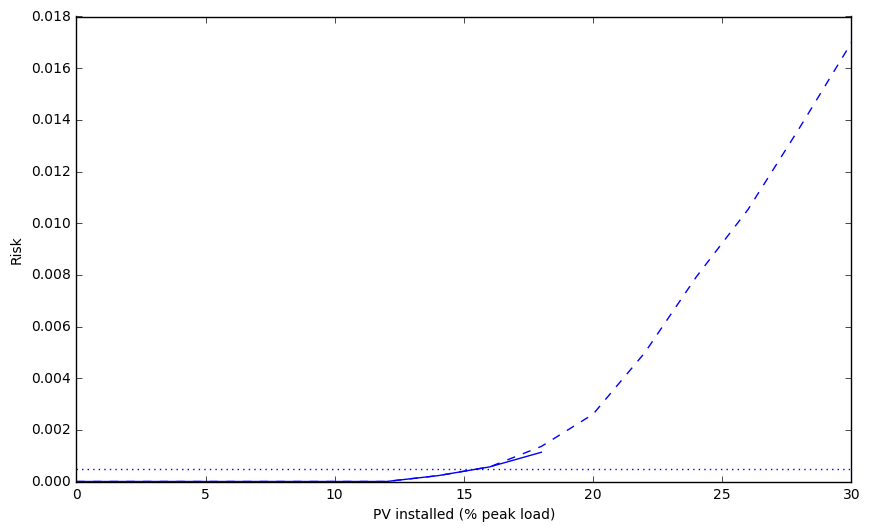

In [103]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
plt.plot(levels_no_curtailment,RiskImbalance_no_curtailment, linestyle='--',color='blue')
plt.plot(levels,[l[3] for l in RiskImbalance],color='blue')
plt.axhline(y=.0005,linestyle=':')
#plt.axvline(x=16,linestyle=':')
plt.xlabel("PV installed (% peak load)")
plt.ylabel("Risk")

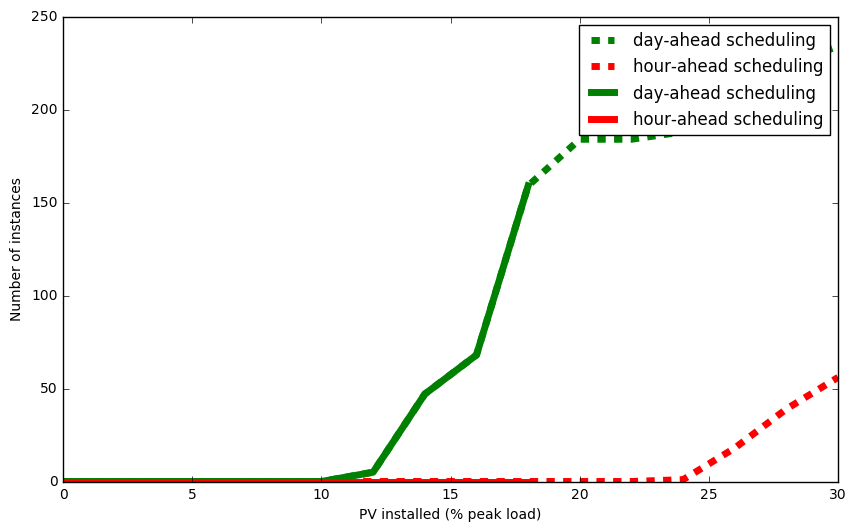

In [104]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
ax1.plot(levels_no_curtailment,DayAheadRampCounts_no_curtailment, color='green', 
         linestyle='--', label = 'day-ahead scheduling',lw=5)
ax1.plot(levels_no_curtailment,HourAheadRampCounts_no_curtailment, color='red', 
         linestyle='--', label = 'hour-ahead scheduling',lw=5)
ax1.plot(levels,DayAheadRampCounts, color='green', label = 'day-ahead scheduling',lw=5)
ax1.plot(levels,HourAheadRampCounts, color='red', label = 'hour-ahead scheduling',lw=5)

ax1.set_xlabel("PV installed (% peak load)")
ax1.set_ylabel("Number of instances")
ax1.legend()

In [94]:
#Compile all we need
levels = range(0,100,5)
DayAheadRampCounts = []
HourAheadRampCounts = []
RiskImbalance = []
for level in levels:
    print "Level: " + str(level)
    Data1 = DayAheadPredictionAndRamprate(Data)
    Data2, DayAheadRampCount = DayAheadMarketAssignment(Data1)
    DayAheadRampCounts.append(DayAheadRampCount)
    Data3 = HourAheadPredictionAndRamprate(Data2)
    Data4, HourAheadRampCount = HourAheadMarketAssignment(Data3)
    HourAheadRampCounts.append(HourAheadRampCount)
    Data5, imbalance_measure = AncillaryServiceCount(Data4)
    RiskImbalance.append(imbalance_measure)

Level: 0


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Level: 5
Level: 10
Level: 15
Level: 20
Level: 25
Level: 30
Level: 35
Level: 40
Level: 45
Level: 50
Level: 55
Level: 60
Level: 65
Level: 70
Level: 75
Level: 80
Level: 85
Level: 90
Level: 95


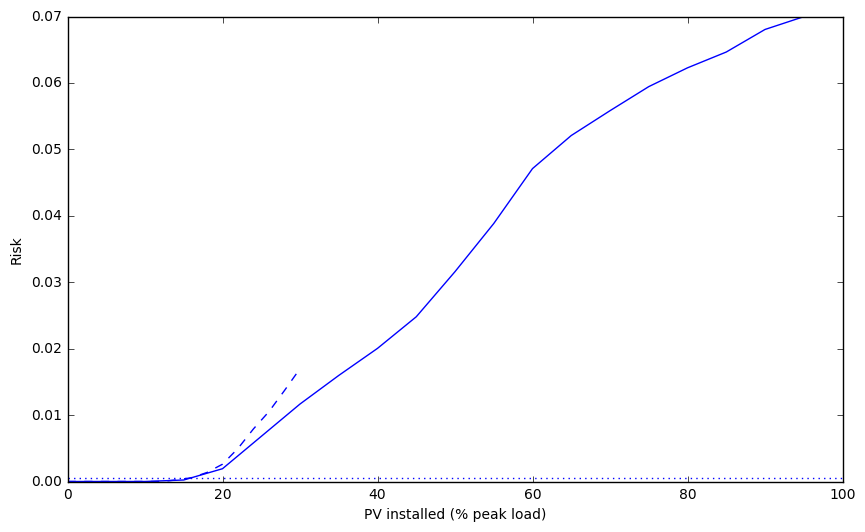

In [96]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
plt.plot(levels_no_curtailment,RiskImbalance_no_curtailment, linestyle='--',color='blue')
plt.plot(levels,[l[3] for l in RiskImbalance],color='blue')
plt.axhline(y=.0005,linestyle=':')
#plt.axvline(x=16,linestyle=':')
plt.xlabel("PV installed (% peak load)")
plt.ylabel("Risk")

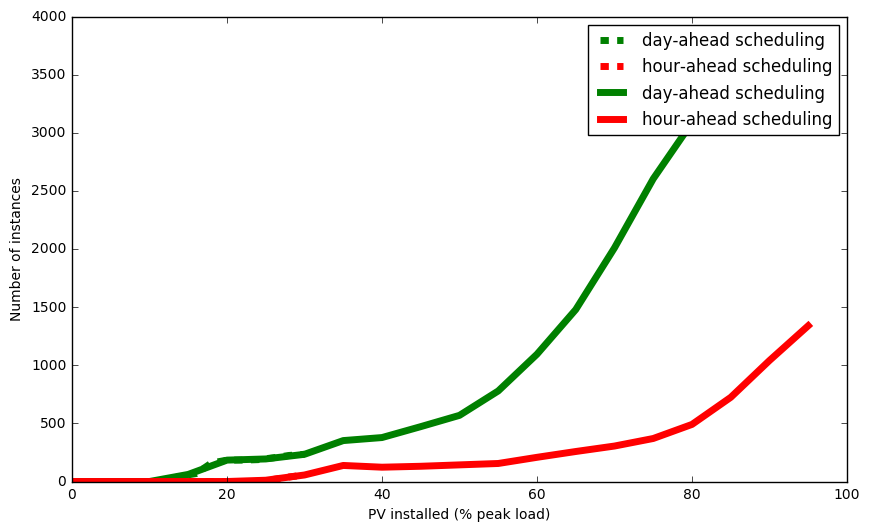

In [97]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
ax1.plot(levels_no_curtailment,DayAheadRampCounts_no_curtailment, color='green', 
         linestyle='--', label = 'day-ahead scheduling',lw=5)
ax1.plot(levels_no_curtailment,HourAheadRampCounts_no_curtailment, color='red', 
         linestyle='--', label = 'hour-ahead scheduling',lw=5)
ax1.plot(levels,DayAheadRampCounts, color='green', label = 'day-ahead scheduling',lw=5)
ax1.plot(levels,HourAheadRampCounts, color='red', label = 'hour-ahead scheduling',lw=5)

ax1.set_xlabel("PV installed (% peak load)")
ax1.set_ylabel("Number of instances")
ax1.legend()

To understand the asymptotic behavior, let's try the large range of PV installation.

In [98]:
#Compile all we need
levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
DayAheadRampCounts = []
HourAheadRampCounts = []
RiskImbalance = []
for level in levels:
    print "Level: " + str(level)
    Data1 = DayAheadPredictionAndRamprate(Data)
    Data2, DayAheadRampCount = DayAheadMarketAssignment(Data1)
    DayAheadRampCounts.append(DayAheadRampCount)
    Data3 = HourAheadPredictionAndRamprate(Data2)
    Data4, HourAheadRampCount = HourAheadMarketAssignment(Data3)
    HourAheadRampCounts.append(HourAheadRampCount)
    Data5, imbalance_measure = AncillaryServiceCount(Data4)
    RiskImbalance.append(imbalance_measure)

Level: 0


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Level: 10
Level: 20
Level: 30
Level: 40
Level: 50
Level: 60
Level: 70
Level: 80
Level: 90
Level: 100
Level: 200
Level: 300
Level: 400
Level: 500
Level: 600
Level: 700
Level: 800
Level: 900
Level: 1000


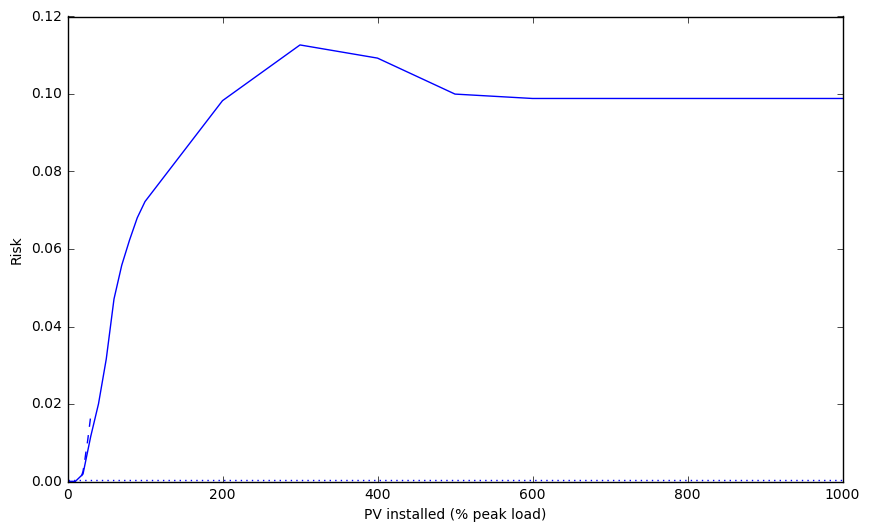

In [99]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
plt.plot(levels_no_curtailment,RiskImbalance_no_curtailment, linestyle='--',color='blue')
plt.plot(levels,[l[3] for l in RiskImbalance],color='blue')
plt.axhline(y=.0005,linestyle=':')
#plt.axvline(x=16,linestyle=':')
plt.xlabel("PV installed (% peak load)")
plt.ylabel("Risk")

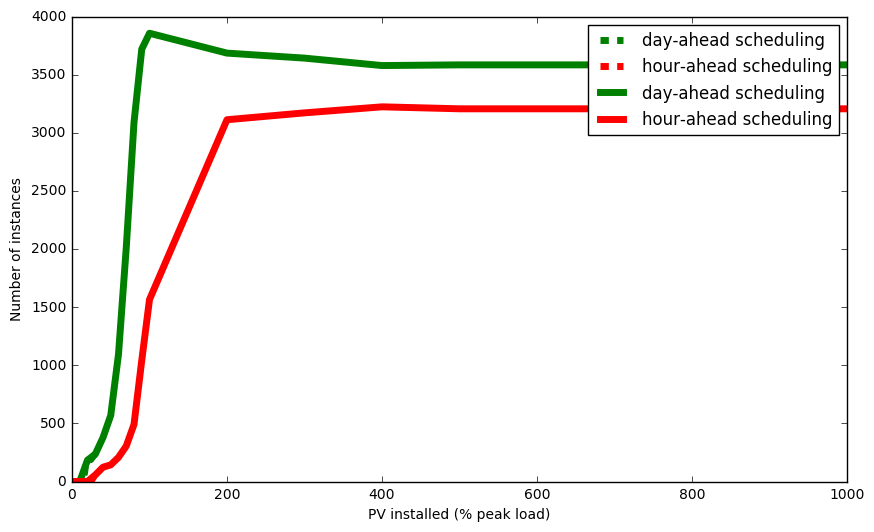

In [100]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
ax1.plot(levels_no_curtailment,DayAheadRampCounts_no_curtailment, color='green', 
         linestyle='--', label = 'day-ahead scheduling',lw=5)
ax1.plot(levels_no_curtailment,HourAheadRampCounts_no_curtailment, color='red', 
         linestyle='--', label = 'hour-ahead scheduling',lw=5)
ax1.plot(levels,DayAheadRampCounts, color='green', label = 'day-ahead scheduling',lw=5)
ax1.plot(levels,HourAheadRampCounts, color='red', label = 'hour-ahead scheduling',lw=5)

ax1.set_xlabel("PV installed (% peak load)")
ax1.set_ylabel("Number of instances")
ax1.legend()

One can see the problem: when the PV penetration is large, the ramp rate is not fast enough to cope. Here is an example (morning and evening).

C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


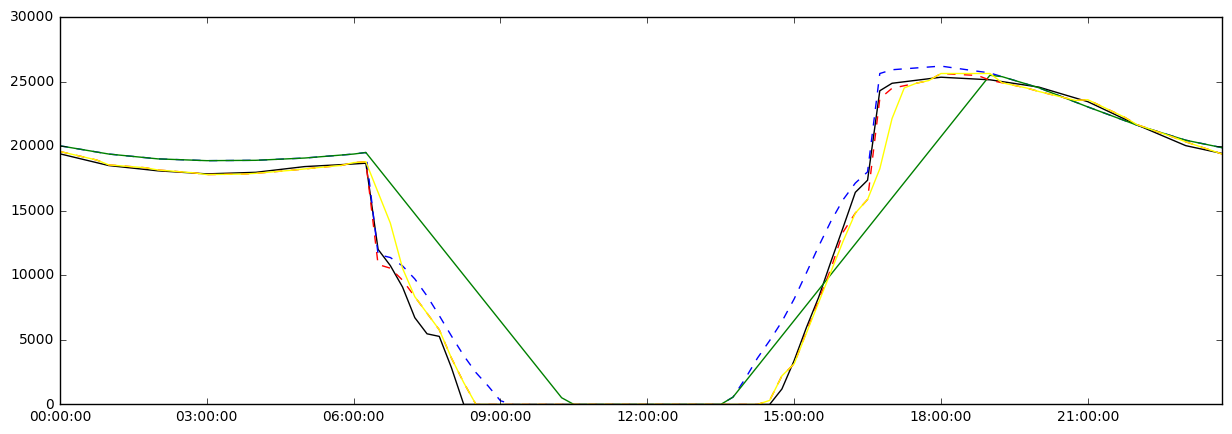

In [109]:
level = 100 
Data1 = DayAheadPredictionAndRamprate(Data)
Data2, DayAheadRampCount = DayAheadMarketAssignment(Data1)
Data3 = HourAheadPredictionAndRamprate(Data2)
Data4, HourAheadRampCount = HourAheadMarketAssignment(Data3)
Data5, imbalance_measure = AncillaryServiceCount(Data4)

fig = plt.figure(figsize=(5*3, 5*1))
l = range(4200,4500)
#l = range(0,Data5.shape[0])
l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,12,7)].index
l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,11,16)].index
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='green',linestyle='-')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='yellow',linestyle='-')